# AirBnB Dataset

table schemata [here](https://docs.google.com/document/d/1ezVFDe506zK1CuuNhNmzHEj_iNnL67hDrFzSap9V7S0/edit?usp=sharing) for the data

In [1]:
import urllib.request
import zipfile
import os

print("Starting download ...")
url = "https://github.com/aihack20/airbnb_challenge/releases/download/data/data-airbnb.zip"
with urllib.request.urlopen(url) as src:
    with open("tmp_airbnb_data.zip", "wb") as dest:
        dest.write(src.read())
print("Unpacking archive ...")
os.makedirs("airbnb_data", exist_ok=True)
with zipfile.ZipFile("tmp_airbnb_data.zip", compression=zipfile.ZIP_DEFLATED) as zip_f:
    zip_f.extractall("airbnb_data")
print("Done!")

Starting download ...
Unpacking archive ...
Done!


In [35]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [25]:
# Load the data (will take a short while)
calendar = pd.read_csv("airbnb_data/calendar.csv")
demographics = pd.read_csv("airbnb_data/demographics.csv")
econ_state = pd.read_csv("airbnb_data/econ_state.csv")
listings = pd.read_csv("airbnb_data/listings.csv")
real_estate = pd.read_csv("airbnb_data/real_estate.csv")
venues = pd.read_csv("airbnb_data/venues.csv")

## Data Cleaning

### Features with missing data deleted

In [26]:
percent_missing = listings.isnull().sum() * 100 / len(listings)
missing_listings_df = pd.DataFrame({'column_name': listings.columns,
                                 'percent_missing': percent_missing})

Text(0, 0.5, 'Percentage missing values')

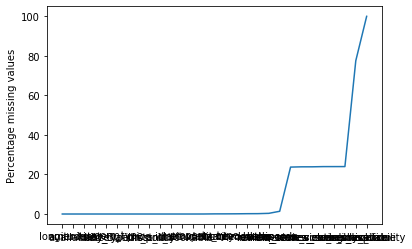

In [27]:
missing_listings_df.sort_values('percent_missing', inplace=True)
plt.plot(missing_listings_df['percent_missing'])
plt.ylabel('Percentage missing values')
# seems natural to drop those at the cutoff for around 20% missing data

In [28]:
missing_listings_df

,column_name,percent_missing
longitude,longitude,0.000000
amenities,amenities,0.000000
availability_30,availability_30,0.000000
state,state,0.000000
bed_type,bed_type,0.000000
room_type,room_type,0.000000
cancellation_policy,cancellation_policy,0.000000
price,price,0.000000
host_id,host_id,0.000000
id,id,0.000000


In [29]:
cols_to_drop = ['has_availability', 'weekly_price', 'review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating', 'host_id', 'id', 'name', 'longitude', 'latitude']
listings_drop = listings.drop(columns=cols_to_drop)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


### Impute missing data in ways that make sense

In [30]:
cols_to_delete_na = ['property_type', 'city', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'zipcode']
listings_drop = listings_drop.dropna(axis=0, subset=cols_to_delete_na)
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


### Now standardise and one-hot encode etc. data

In [31]:
cols_to_scale = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
listings_drop[cols_to_scale] = scaler.fit_transform(listings_drop[cols_to_scale])

In [32]:
listings_drop.head(4)

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,instant_bookable,metropolitan,price,property_type,room_type,state,zipcode
0,-0.518121,"{""Cable TV"",""Wireless Internet"",""Air condition...",1.599729,-0.379388,Real Bed,-0.286649,-0.555898,moderate,sunnysidebronx,f,NYC,99.0,House,Private room,NY,10464
1,0.480388,"{TV,Internet,""Wireless Internet"",""Air conditio...",2.197547,-0.379388,Real Bed,-0.286649,-0.555898,flexible,sunnysidebronx,t,NYC,200.0,Apartment,Private room,NY,10464
2,0.480388,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2.197547,3.746315,Real Bed,2.286144,1.213739,strict,sunnysidebronx,f,NYC,300.0,House,Entire home/apt,NY,10464
3,-0.018867,"{TV,Internet,""Wireless Internet"",""Air conditio...",0.005549,-0.379388,Real Bed,-0.286649,-0.555898,strict,long island city,f,NYC,125.0,Apartment,Entire home/apt,NY,10464


### PCA to turn discrete data into explainable encoded data

#### example

In [63]:
pca = PCA(n_components=0.9, svd_solver='full')
cols_to_onehot = ['cancellation_policy', 'city', 'instant_bookable', 'metropolitan', 'property_type', 'room_type', 'state']
# doesnt include bed_type, example below
listings_onehot = pd.get_dummies(listings_drop['bed_type'] ,prefix='bed_type')

In [59]:
listings_onehot

,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
59819,0,0,0,0,1
59820,0,0,0,0,1
59821,0,0,0,0,1
59822,0,0,0,0,1


In [65]:
principle_comps = pca.fit_transform(listings_onehot)
principle_df = pd.DataFrame(data=principle_comps).add_prefix('bed_type' + '_')

In [66]:
principle_df

,bed_type_0,bed_type_1,bed_type_2
0,-0.03455,-0.000749,-0.000578
1,-0.03455,-0.000749,-0.000578
2,-0.03455,-0.000749,-0.000578
3,-0.03455,-0.000749,-0.000578
4,-0.03455,-0.000749,-0.000578
...,...,...,...
58582,-0.03455,-0.000749,-0.000578
58583,-0.03455,-0.000749,-0.000578
58584,-0.03455,-0.000749,-0.000578
58585,-0.03455,-0.000749,-0.000578


### now do this for all other discrete variables

In [67]:
for col in cols_to_onehot:
    pca = PCA(n_components=0.9, svd_solver='full')
    listings_onehot = pd.get_dummies(listings_drop[col] ,prefix=col)
    principle_comps = pca.fit_transform(listings_onehot)
    principle_df_add = pd.DataFrame(data=principle_comps).add_prefix(col + '_')
    principle_df = pd.concat([principle_df, principle_df_add], axis=1)

In [68]:
principle_df

,bed_type_0,bed_type_1,bed_type_2,cancellation_policy_0,cancellation_policy_1,city_0,city_1,city_2,city_3,city_4,city_5,instant_bookable_0,metropolitan_0,metropolitan_1,metropolitan_2,property_type_0,property_type_1,property_type_2,property_type_3,room_type_0,state_0,state_1,state_2
0,-0.03455,-0.000749,-0.000578,-0.289947,0.870112,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,-0.304075,-0.362460,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,0.779877,-0.362315,-0.024807,-0.013270
1,-0.03455,-0.000749,-0.000578,-0.681225,-0.488895,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,1.110138,-0.362460,-0.025105,-0.013274,-0.269633,-0.031114,-0.003300,-0.001324,0.779877,-0.362315,-0.024807,-0.013270
2,-0.03455,-0.000749,-0.000578,0.691348,-0.148247,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,-0.304075,-0.362460,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,-0.634313,-0.362315,-0.024807,-0.013270
3,-0.03455,-0.000749,-0.000578,0.691348,-0.148247,0.056624,0.219300,0.131767,0.133746,0.076506,0.030762,-0.304075,-0.362460,-0.025105,-0.013274,-0.269633,-0.031114,-0.003300,-0.001324,-0.634313,-0.362315,-0.024807,-0.013270
4,-0.03455,-0.000749,-0.000578,-0.289947,0.870112,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,1.110138,-0.362460,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,0.779877,-0.362315,-0.024807,-0.013270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58582,-0.03455,-0.000749,-0.000578,-0.681225,-0.488895,0.056236,0.216752,0.129155,0.129672,0.073333,0.029269,1.110138,0.924611,-0.597152,-0.132172,-0.269633,-0.031114,-0.003300,-0.001324,0.779877,0.503188,0.134631,0.118027
58583,-0.03455,-0.000749,-0.000578,-0.681225,-0.488895,0.056223,0.216669,0.129070,0.129541,0.073233,0.029222,-0.304075,0.924611,-0.597152,-0.132172,-0.269633,-0.031114,-0.003300,-0.001324,-0.634313,0.503188,0.134631,0.118027
58584,-0.03455,-0.000749,-0.000578,0.691348,-0.148247,0.056217,0.216627,0.129028,0.129476,0.073183,0.029199,1.110138,0.924611,-0.597152,-0.132172,1.126372,-0.256310,-0.021228,-0.008199,0.779877,0.503188,0.134631,0.118027
58585,-0.03455,-0.000749,-0.000578,-0.289947,0.870112,0.056236,0.216752,0.129155,0.129672,0.073333,0.029269,1.110138,0.924611,-0.597152,-0.132172,0.586301,0.890860,-0.636881,-0.107313,-0.634313,0.503188,0.134631,0.118027


In [72]:
final_df = pd.concat([listings_drop, principle_df], axis=1)
final_df = final_df.drop(columns=cols_to_onehot)

# for now drop amenities and zipcode too (and bed_type, which was left out before)
final_df = final_df.drop(columns=['zipcode', 'amenities'])

In [73]:
final_df.head(5)

,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,price,bed_type_0,bed_type_1,bed_type_2,cancellation_policy_0,cancellation_policy_1,city_0,city_1,city_2,city_3,city_4,city_5,instant_bookable_0,metropolitan_0,metropolitan_1,metropolitan_2,property_type_0,property_type_1,property_type_2,property_type_3,room_type_0,state_0,state_1,state_2
0,-0.518121,1.599729,-0.379388,Real Bed,-0.286649,-0.555898,99.0,-0.03455,-0.000749,-0.000578,-0.289947,0.870112,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,-0.304075,-0.36246,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,0.779877,-0.362315,-0.024807,-0.01327
1,0.480388,2.197547,-0.379388,Real Bed,-0.286649,-0.555898,200.0,-0.03455,-0.000749,-0.000578,-0.681225,-0.488895,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,1.110138,-0.36246,-0.025105,-0.013274,-0.269633,-0.031114,-0.003300,-0.001324,0.779877,-0.362315,-0.024807,-0.01327
2,0.480388,2.197547,3.746315,Real Bed,2.286144,1.213739,300.0,-0.03455,-0.000749,-0.000578,0.691348,-0.148247,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,-0.304075,-0.36246,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,-0.634313,-0.362315,-0.024807,-0.01327
3,-0.018867,0.005549,-0.379388,Real Bed,-0.286649,-0.555898,125.0,-0.03455,-0.000749,-0.000578,0.691348,-0.148247,0.056624,0.219300,0.131767,0.133746,0.076506,0.030762,-0.304075,-0.36246,-0.025105,-0.013274,-0.269633,-0.031114,-0.003300,-0.001324,-0.634313,-0.362315,-0.024807,-0.01327
4,0.480388,0.902276,-0.379388,Real Bed,-0.286649,-0.555898,69.0,-0.03455,-0.000749,-0.000578,-0.289947,0.870112,0.058367,0.231042,0.144386,0.154763,0.094102,0.039467,1.110138,-0.36246,-0.025105,-0.013274,1.126372,-0.256310,-0.021228,-0.008199,0.779877,-0.362315,-0.024807,-0.01327


#### removing correlated features

In [76]:
def trim_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [82]:
final_df_reduced = trim_correlated(final_df, 0.9)

In [86]:
before = len(final_df.columns)
after = len(final_df_reduced.columns)
print('cols before correlation reduction: {}\ncols after correlation reduction: {}'.format(before, after))

cols before correlation reduction: 30
cols after correlation reduction: 23


## Running a simple model on our data

In [55]:
def listing_map(df, listing_id):
    df = df[df["listing_id"] == listing_id]
    d = {'t': 1, 'f': 0}
    df['available'] = df['available'].map(d)
    return df

In [52]:
listing = listing_map(random)

,listing_id,date,available,price,metro_area
3022930,4194494,2018-05-01,0,NaN,NYC
3022931,4194494,2018-04-30,0,NaN,NYC
3022932,4194494,2018-04-29,0,NaN,NYC
3022933,4194494,2018-04-28,0,NaN,NYC
3022934,4194494,2018-04-27,0,NaN,NYC
3022935,4194494,2018-04-26,0,NaN,NYC
3022936,4194494,2018-04-25,0,NaN,NYC
3022937,4194494,2018-04-24,0,NaN,NYC
3022938,4194494,2018-04-23,0,NaN,NYC
3022939,4194494,2018-04-22,0,NaN,NYC


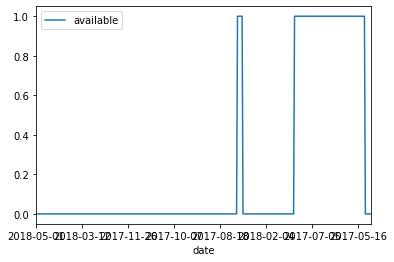

In [53]:
ax = plt.gca()
listing.plot(kind='line',x='date',y='available',ax=ax)

## Make a Simple Neural Net on Limited Features

In [142]:
X = listings[["bedrooms", "price", "review_scores_rating", "review_scores_value", "zipcode"]]
X = X.dropna()
X

,bedrooms,price,review_scores_rating,review_scores_value,zipcode
0,1.0,99.0,100.0,10.0,10464
3,1.0,125.0,93.0,10.0,10464
4,1.0,69.0,97.0,10.0,10464
5,0.0,125.0,97.0,10.0,10464
6,1.0,85.0,98.0,10.0,10464
...,...,...,...,...,...
59808,1.0,130.0,94.0,10.0,20003
59809,0.0,95.0,100.0,10.0,20002
59815,0.0,50.0,100.0,10.0,20712
59819,1.0,42.0,80.0,9.0,20910


In [143]:
zipcodes_dem = list(set(demographics["zipcode"]))
zipcodes_list = list(set(X["zipcode"]))

In [144]:
zip_to_mean_income = {}

for z in zipcodes_list:
    if z in zipcodes_dem:
        zip_to_mean_income[z] = int(demographics[demographics["zipcode"]==z]["mean_household_income"].values)

In [145]:
X['mean_income'] = X["zipcode"]
for index, row in X.iterrows():
    X.at[index, 'mean_income'] = zip_to_mean_income[int(row["zipcode"])]
X

KeyError: 10464

In [78]:
y_target = X["price"]
del X["price"]

In [72]:
trainX, valX, testX = np.split(df.sample(frac=1), [int(.7*len(df)), int(.85*len(df))])

In [75]:
train

,bedrooms,price,review_scores_rating,review_scores_value
5079,1.0,70.0,100.0,8.0
42618,1.0,69.0,80.0,8.0
51204,0.0,75.0,100.0,10.0
12039,2.0,62.0,95.0,10.0
24465,1.0,210.0,100.0,10.0
...,...,...,...,...
34470,0.0,150.0,100.0,10.0
13468,1.0,85.0,100.0,10.0
23499,1.0,59.0,85.0,9.0
52282,1.0,115.0,97.0,10.0
